# Źródło

https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

# Kod

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import os
mainDriveRoot = '/content/drive/My Drive/'
training_set_folder_filePath = mainDriveRoot + 'training_set/'
train_labels_path = mainDriveRoot + 'stage_2_train_labels.csv'
print(training_set_folder_filePath)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/training_set/


In [0]:
import matplotlib.pyplot as plt
!pip install pydicom
import pydicom
import random

    100% |████████████████████████████████| 7.0MB 5.7MB/s 


In [0]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
print(training_set_folder_filePath)

/content/drive/My Drive/training_set/


In [0]:
import glob
all_dicom_files = glob.glob(training_set_folder_filePath + '*.dcm') 

In [0]:
random.shuffle(all_dicom_files)

In [0]:
print('Size of training set {}'.format(len(all_dicom_files)))

Size of training set 26684


In [0]:
import csv

def get_labels(train_labels_csv_path):
  with open(train_labels_path) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    return list(reader)
labels = get_labels(train_labels_path)

attributes = labels[0]
print(attributes)
labels = labels[1:]

['patientId', 'x', 'y', 'width', 'height', 'Target']


In [0]:
def extract_file_name_from_path(filePath):
    fileNameWithExt = os.path.basename(filePath)
    fileNameAndExt = os.path.splitext(fileNameWithExt)
    fileName = fileNameAndExt[0]
    return fileName
  
def label_row_to_label(row):
  return row[5] == '1'

def find_label_by_id(labels, id):
  for label in labels:
    if label[0] == id:
      return label
    
def get_labels_for_training_set(dicom_files, csv_labels):
  labels = []
  training_set_files = []
  for dicom_file_path in dicom_files:
    fileName = extract_file_name_from_path(dicom_file_path)
    label_row = find_label_by_id(csv_labels, fileName)
   
    if label_row != None:   
      label = label_row_to_label(label_row)
      labels.append(label)
      training_set_files.append(dicom_file_path)
  return (training_set_files, labels)

In [0]:
training_set_files, true_labels = get_labels_for_training_set(all_dicom_files, labels)

In [0]:
import cv2
import numpy as np

def pre_process_image(dicom_image):
  resized_image_size = 128
  img = cv2.resize(dicom_image, dsize=(resized_image_size, resized_image_size), interpolation=cv2.INTER_CUBIC)
  
  #img = cv2.equalizeHist(img)
  #img = binarize_and_morph_image(img)
  return img

def binarize_and_morph_image(img):
  #ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
  img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C , cv2.THRESH_BINARY,11,3)
  
  kernel_size = 2
  kernel = np.ones((kernel_size,kernel_size), np.uint8)
  #img = cv2.erode(img, kernel, iterations=1)
  img = cv2.dilate(img, kernel, iterations=1)
  return img

In [0]:
def getDicom(filePath):
  return pydicom.dcmread(filePath)

#1 for man 0 for woman
def get_sex(dicom):
  return dicom.PatientSex == 'M'
def get_age(dicom):
  return int(dicom.PatientAge)

In [0]:
from tqdm import tqdm

In [0]:
def load_dicoms_with_labels(training_set_files, labels, start, end):
  dicoms = []
  dicom_labels = []
  for i in tqdm(range(start,end), desc = "pobieranie dicomow"):
    dicom_file_path = training_set_files[i]
    dicom = getDicom(dicom_file_path)
    dicoms.append(dicom)
    dicom_labels.append(labels[i])
  return dicoms, dicom_labels

In [0]:
(dicoms, labels) = load_dicoms_with_labels(training_set_files, true_labels, 0, 7000)


pobieranie dicomow: 100%|██████████| 7000/7000 [06:13<00:00,  3.42it/s]

pobieranie dicomow: 100%|██████████| 7000/7000 [00:58<00:00, 120.50it/s]

In [0]:
import time


def prepare_data(dicoms, labels):
  processed_set = []
  target_labels = []
  for i in tqdm(range(0,len(labels)), desc = "przetwarzanie danych wejściowych"):
    dicom = dicoms[i]
    dicom_sex = get_sex(dicom)
    dicom_age = get_age(dicom)
    #if(dicom_sex == False and (dicom_age > 16 and dicom_age < 50)):
    if(dicom_age > 16 and dicom_age < 50):
      processed_image = pre_process_image(dicom.pixel_array)
      processed_set.append(processed_image)
      target_labels.append(labels[i]) 
  processed_set = np.array(processed_set).astype('float32')
  processed_set /= 255  
  processed_set = np.expand_dims(processed_set, axis=-1)
  
  target_labels = np.array(target_labels)
  
  return (processed_set, target_labels)

In [0]:
(processed_set, target_labels) =  prepare_data(dicoms, labels)


przetwarzanie danych wejściowych: 100%|██████████| 7000/7000 [00:15<00:00, 441.04it/s]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28350.1517874484.638321
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '345d4363-a4e6-47f4-97c8-9bbd22061ae9'
(0010, 0020) Patient ID                          LO: '345d4363-a4e6-47f4-97c8-9bbd22061ae9'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

Text(0.5, 1.0, 'obraz po wyrownaniu histogramu')

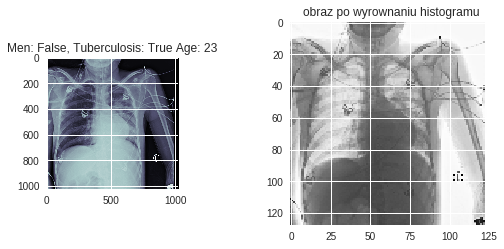

In [0]:
from random import randrange

def showDicomImage(dicomSource, dicom_label):
    sex_label = get_sex(dicomSource)
    plt.imshow(dicomSource.pixel_array, cmap=plt.cm.bone)
    plt.title('Men: %s, Tuberculosis: %s Age: %s' % (sex_label, dicom_label, dicomSource.PatientAge)) 
 
random_index = randrange(len(dicoms))
dicom_label = labels[random_index]
dicom = dicoms[random_index] 
#dicom_hu = get_pixels_hu(dicom)

print(dicom)
plt.subplot(1,3, 1)
showDicomImage(dicom, dicom_label)
plt.subplot(1,2, 2)
plt.imshow(pre_process_image(dicom.pixel_array))
plt.title('obraz po wyrownaniu histogramu')

In [0]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization

In [0]:
def alex_net():
    model = Sequential()
    model.add(Conv2D(32, (2, 2), input_shape=(128,128,1)))
    model.add(Activation('relu'))       
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))
      
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))   
      
    model.add(Conv2D(128, (2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(256, (2, 2), activation='relu'))
    model.add(Conv2D(256, (2, 2), activation='relu'))  
    model.add(Conv2D(512, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
def vgg_10():
    model = Sequential()
    kernel_size = 3
    pool = 3
    pool2 = 2
    
    model.add(Conv2D(64, kernel_size, activation='relu', input_shape=(128,128,1)))    
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(MaxPooling2D(pool_size=pool2))
        
    model.add(Conv2D(64, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=pool))
      
    model.add(Conv2D(128, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(MaxPooling2D(pool_size=pool2))
    
    model.add(Conv2D(256, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(256, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool2))  
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
model = None
import gc
if model is not None:
  del model
  gc.collect()

In [0]:
model = vgg_10()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 126, 126, 64)      640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 126, 126, 64)      256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 126, 126, 64)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 20, 20, 64)        0         
__________

https://arxiv.org/pdf/1412.6806.pdf
http://papers.nips.cc/paper/4878-understanding-dropout.pdf
https://arxiv.org/pdf/1412.6980v8.pdf

In [0]:
pivotIndex = 850
pivotIndex2 = 1100
end = 1350
training_set = processed_set[:pivotIndex]
training_labels = target_labels[:pivotIndex]
validation_set = processed_set[pivotIndex:pivotIndex2] 
validation_labels = target_labels[pivotIndex:pivotIndex2]
test_set = processed_set[pivotIndex2:end]
test_labels = target_labels[pivotIndex2:end]
print('Training set shape {} Labels shape {}'.format(training_set.shape, training_labels.shape))
print('Validation set shape {} Labels shape {}'.format(validation_set.shape, validation_labels.shape))
print('Test set shape {} Labels shape {}'.format(test_set.shape, test_labels.shape))

Training set shape (850, 128, 128, 1) Labels shape (850,)
Validation set shape (250, 128, 128, 1) Labels shape (250,)
Test set shape (250, 128, 128, 1) Labels shape (250,)


In [0]:
history = model.fit(training_set,training_labels,validation_data=(validation_set, validation_labels), batch_size=100, epochs=40, shuffle=True)

Train on 850 samples, validate on 250 samples
Epoch 1/40
850/850 [==============================] - 2s 3ms/step - loss: 0.5996 - acc: 0.7565 - val_loss: 0.6151 - val_acc: 0.7680
Epoch 2/40
850/850 [==============================] - 1s 1ms/step - loss: 0.5403 - acc: 0.7824 - val_loss: 0.5944 - val_acc: 0.7680
Epoch 3/40
850/850 [==============================] - 1s 1ms/step - loss: 0.5386 - acc: 0.7824 - val_loss: 0.5775 - val_acc: 0.7680
Epoch 4/40
850/850 [==============================] - 1s 1ms/step - loss: 0.5343 - acc: 0.7824 - val_loss: 0.5482 - val_acc: 0.7680
Epoch 5/40
850/850 [==============================] - 1s 1ms/step - loss: 0.5224 - acc: 0.7824 - val_loss: 0.5338 - val_acc: 0.7680
Epoch 6/40
850/850 [==============================] - 1s 1ms/step - loss: 0.5125 - acc: 0.7824 - val_loss: 0.5102 - val_acc: 0.7680
Epoch 7/40
850/850 [==============================] - 1s 1ms/step - loss: 0.5009 - acc: 0.7824 - val_loss: 0.4924 - val_acc: 0.7680
Epoch 8/40
850/850 [==========

In [0]:
score = model.evaluate(test_set, test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 0s 387us/step
Test loss: 0.43665279269218443
Test accuracy: 0.7840000009536743


In [0]:
random_test_index = randrange(len(test_labels))

prediction_binary = model.predict_classes(test_set).astype(bool)
print('Random dicom prediction: {}, random dicom label: {}'.format(prediction_binary[random_test_index],test_labels[random_test_index]))

Random dicom prediction: [False], random dicom label: False


In [0]:
import keras
test_labels_int = test_labels.astype(int)
prediction_int = prediction_binary.astype(int)
keras.metrics.binary_accuracy(test_labels_int, prediction_binary.astype(int))

import sklearn.metrics as metrics
matrix = metrics.confusion_matrix(test_labels_int, prediction_int, labels=[0,1])
print(matrix)

report = metrics.classification_report(test_labels_int, prediction_int)
print(report)  

[[166  30]
 [ 24  30]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       196
           1       0.50      0.56      0.53        54

   micro avg       0.78      0.78      0.78       250
   macro avg       0.69      0.70      0.69       250
weighted avg       0.79      0.78      0.79       250



dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


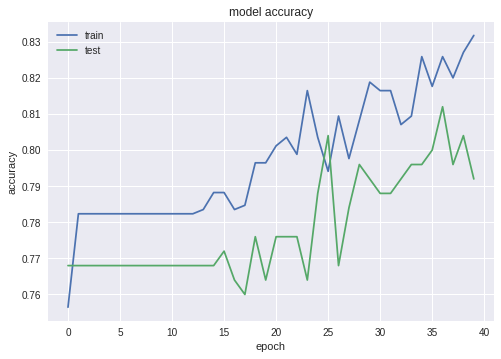

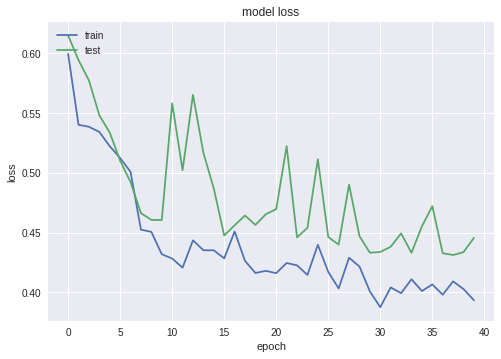

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc ='upper left')
plt.show()

https://stats.stackexchange.com/questions/255105/why-is-the-validation-accuracy-fluctuating